In [4]:
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.ndimage import rotate
import tensorflow_addons as tfa

# Speech Denoising Using Deep Learning

In [2]:
s, sr=librosa.load('data 1.06.31 PM/train_clean_male.wav', sr=None)
S=librosa.stft(s, n_fft=1024, hop_length=512)
sn, sr=librosa.load('data 1.06.31 PM/train_dirty_male.wav', sr=None)
X=librosa.stft(sn, n_fft=1024, hop_length=512)

s_valid, sr=librosa.load('data 1.06.31 PM/test_s_01.wav', sr=None)
S_valid_cmplx=librosa.stft(s_valid, n_fft=1024, hop_length=512)
sn_valid, sr=librosa.load('data 1.06.31 PM/test_x_01.wav', sr=None)
X_valid_cmplx=librosa.stft(sn_valid, n_fft=1024, hop_length=512)

In [3]:
X_train = np.abs(X)
Y_train = np.abs(S)
X_valid = np.abs(X_valid_cmplx)
Y_valid = np.abs(S_valid_cmplx)

In [ ]:
class SNRCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_valid, s_valid, X_valid_cmplx):
        self.X_valid = X_valid
        self.s_valid = s_valid
        self.X_valid_cmplx = X_valid_cmplx
        self.best_snr = -float('inf')
        self.snrs = []

    def on_epoch_end(self, epoch, logs=None):
        S_hat_abs_T = self.model.predict(self.X_valid.T)
        S_hat_abs = S_hat_abs_T.T
        S_hat = (self.X_valid_cmplx/self.X_valid) * S_hat_abs
        s_hat = librosa.istft(S_hat, win_length=1024, hop_length=512)
        s_valid = self.s_valid[0:len(s_hat)]
        num = np.sum(np.square(self.s_valid))
        den = np.sum(np.square(s_valid - s_hat))
        snr = 10 * np.log(num / den)

        self.snrs.append(snr)  # Append SNR value for this epoch

        print(f'Epoch {epoch + 1} - Validation SNR: {snr} dB')



In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=20,
    restore_best_weights=True
)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(513,)),
    tf.keras.layers.Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.5), kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.5), kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.5), kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(513, activation='softplus', kernel_initializer='glorot_uniform'),
])

X_train_T = X_train.T  # Transpose X_train to (2459, 513)
Y_train_T = Y_train.T
X_valid_T = X_valid.T
Y_valid_T = Y_valid.T

snr_callback = SNRCallback(X_valid, s_valid, X_valid_cmplx)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

BATCH_SIZE = 32
EPOCHS = 600
Accuracy = model.fit(X_train_T, Y_train_T,
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     callbacks=[snr_callback, early_stopping],
                     validation_data=(X_valid_T, Y_valid_T)
                     )

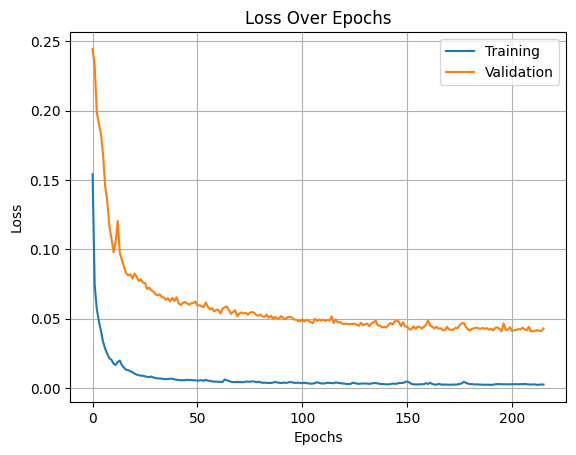

In [ ]:
# Plot of the validation accuracy over epochs
plt.figure()
plt.plot(Accuracy.history['loss'], label='Training')
plt.plot(Accuracy.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

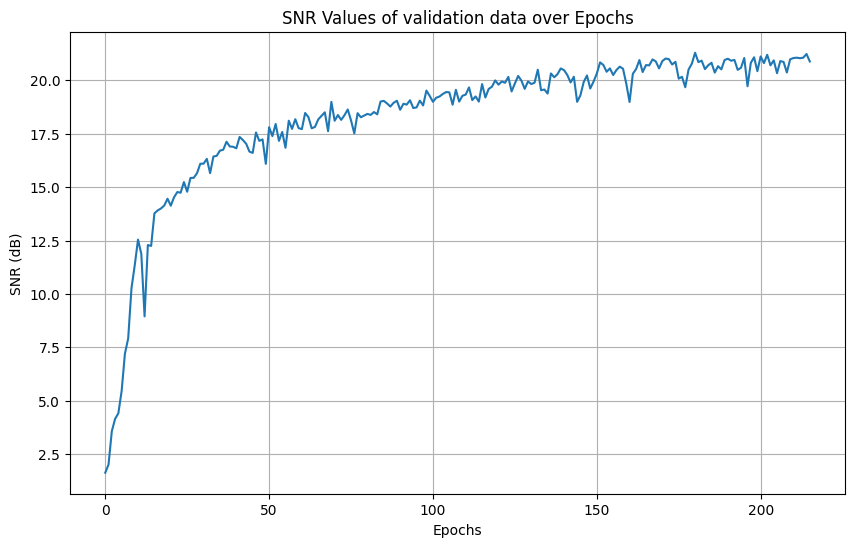

In [ ]:
snr_values = snr_callback.snrs

# Plot SNR values
plt.figure(figsize=(10, 6))
plt.plot(snr_values, linestyle='-')
plt.title('SNR Values of validation data over Epochs')
plt.xlabel('Epochs')
plt.ylabel('SNR (dB)')
plt.grid(True)
plt.show()

In [ ]:
S_hat_abs_T = model.predict(X_valid_T)
S_hat_abs = S_hat_abs_T.T
S_hat = (X_valid_cmplx/X_valid) * S_hat_abs

In [ ]:
print("Noisy Audio Signal")
display(Audio(data=sn_valid, rate=sr))

print("Original Clean Audio Signal")
display(Audio(data=s_valid, rate=sr))

s_hat = librosa.istft(S_hat, win_length=1024, hop_length=512)
print("Reconstructed Clean Audio Signal")
display(Audio(data=s_hat, rate=sr))

Noisy Audio Signal


Original Clean Audio Signal


Reconstructed Clean Audio Signal


In [ ]:
s_valid = s_valid[0:len(s_hat)]
num = np.sum(np.square(s_valid))
den = np.sum(np.square(s_valid - s_hat))
SNR = 10 * np.log(num / den)
print('The SNR value on the validation data is', SNR)

The SNR value on the validation data is 21.045024394989014


In [ ]:
x_test, sr=librosa.load('data 1.06.31 PM/test_x_02.wav', sr=None)
X_test_cmplx=librosa.stft(x_test, n_fft=1024, hop_length=512)
X_test = np.abs(X_test_cmplx)

S_test_hat_abs_T = model.predict(X_test.T)
S_test_hat_abs = S_test_hat_abs_T.T
S_test_hat = (X_test_cmplx/X_test) * S_test_hat_abs

12/12 [==============================] - 0s 686us/step


In [ ]:
print("Noisy Audio Signal")
display(Audio(data=x_test, rate=sr))

s_test_hat = librosa.istft(S_test_hat, win_length=1024, hop_length=512)
print("Reconstructed Clean Audio Signal")
display(Audio(data=s_test_hat, rate=sr))

Noisy Audio Signal


Reconstructed Clean Audio Signal
